In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
work = '/work/08811/aew492/ls6/small-scale_cross-corrs'
scratch = '/scratch/08811/aew492/small-scale_cross-corrs'

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
import astropy.cosmology.units as cu
import os
import sys
sys.path.insert(0, work)
from illustris_sim import IllustrisSim
import corrfunc_ls
import tools

In [4]:
def get_LRG_galaxies(sim, n=2e-4, LRG_cutval=-9.09, V=(205 * u.Mpc/cu.littleh)**3):
    """
    Make cuts in subhalo sSFR and stellar mass to select for LRGs and reach a target galaxy number density,
    as outlined in Sullivan, Prijon, & Seljak (2023).
    """
    # load the subhalo positions, star formation rate and stellar masses
    sim.load_subfind_subhalos()  # loads table of subhalos and removes any flagged
    sim.load_stellar_mass()      # pulls out stellar mass and gives proper units
    sim.load_SFR()               # pulls out SFR and gives proper units
    
    # take only the subhalos with nonzero stellar mass and SFR
    idx_nonzero = (sim.stellar_mass > 0) & (sim.SFR > 0)
    subhalos_nonzero = sim.subhalo_info[idx_nonzero]
    stellar_mass = sim.stellar_mass[idx_nonzero]
    SFR = sim.SFR[idx_nonzero]
    
    # specific star formation rate (sSFR) = star formation rate per stellar mass; and make cut
    sSFR = SFR / stellar_mass
    subhalos_LRG = subhalos_nonzero[np.log10(sSFR.value) < LRG_cutval]
    
    # target number of galaxies
    target_N = int(V * n * (u.Mpc / cu.littleh)**(-3))
    # sort subhalos by decreasing stellar mass, then take only the first nsubhalos
    galaxies = subhalos_LRG[np.argsort(stellar_mass[np.log10(sSFR.value) < LRG_cutval])[::-1]][:target_N]
    return galaxies

In [5]:
snapshots = [99, 50, 40, 33, 17]
redshifts = np.empty(len(snapshots))
gals = []
for i, snapshot in enumerate(snapshots):
    sim = IllustrisSim('TNG300-3', snapshot=snapshot)
    print(sim.redshift)
    redshifts[i] = sim.redshift
    gals.append(get_LRG_galaxies(sim))

0.0
1.0
1.5
2.0
5.0


#### galaxy 2pcf

In [6]:
# parameters
randmult = 3
rmin = 1
rmax = 75.
nbins = 20
nthreads = 12
print(rmin, rmax, nbins)

1 75.0 20


In [7]:
nrepeats = 10
xi_galss = np.empty((len(gals), nbins))
for i, galaxy_info in enumerate(gals):
    print(redshifts[i])
    galaxy_pos = (galaxy_info['SubhaloPos'] * u.kpc).to(u.Mpc)
    xi_gals = np.empty((nrepeats, nbins))
    for j in range(nrepeats):
        ravg, xi_gals[j] = corrfunc_ls.compute_3D_ls_auto(galaxy_pos.value, randmult, rmin, rmax,
                                            nbins, logbins=True, periodic=True, nthreads=nthreads, prints=False)
    xi_galss[i] = np.nanmean(xi_gals, axis=0)
xi_galss.shape

0.0
1.0
1.5
2.0
5.0


/tmp/ipykernel_2846677/3714283049.py:10: RuntimeWarning: Mean of empty slice
  xi_galss[i] = np.nanmean(xi_gals, axis=0)


(5, 20)

In [8]:
# linear theory
xi_linears = np.array([tools.linear_2pcf(z, ravg) for z in redshifts])

In [9]:
# color map
cmap = mpl.colormaps['cool']
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

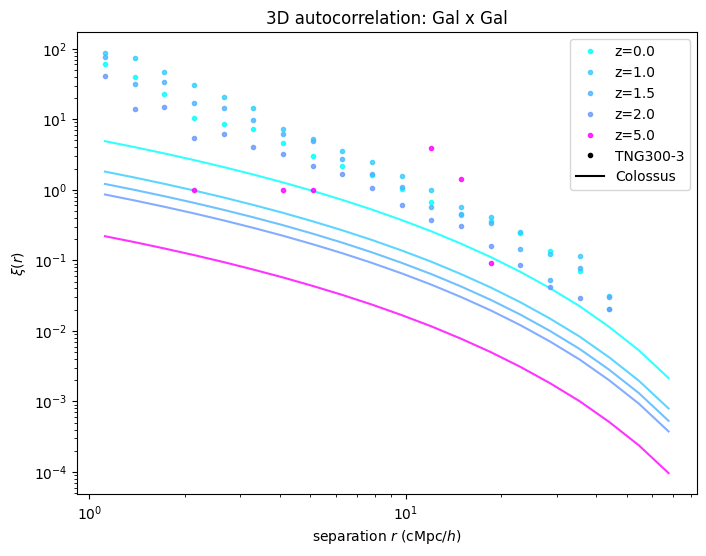

In [10]:
fig, ax = plt.subplots(figsize=(8,6))

for i, redshift in enumerate(redshifts):
    ax.plot(ravg, xi_galss[i], c=smap.to_rgba(redshift), marker='.', ls='None', alpha=0.8, label=f'z={redshift}')
    ax.plot(ravg, xi_linears[i], c=smap.to_rgba(redshift), alpha=0.8)

# labels for TNG vs Colossus
point = mpl.lines.Line2D([0], [0], label='TNG300-3', marker='.', color='k', ls='None')
line = mpl.lines.Line2D([0], [0], label='Colossus', color='k')
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([point, line])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'separation $r$ (cMpc/$h$)')
ax.set_ylabel(r'$\xi (r)$')
ax.set_title(r'3D autocorrelation: Gal x Gal')
ax.legend(handles=handles)